Import libraries

In [1]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
import fiona
import os
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

Save the working directory with data and where you will write the outputs.

In [2]:
wd = "D:/4.LS/MEDPZ/semestralka/final/3+"
rootdir = wd + "/snimek"

Walk through the folder with downloaded satellite imagery and save the B03 and B11 20 m bands into a list named ```source```.

In [5]:
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if(os.path.join(subdir, file).endswith("B03_20m.jp2") or os.path.join(subdir, file).endswith("B11_20m.jp2")):
            source.append(os.path.join(subdir, file))

source

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B11_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG

Fill two lists ```unique_dates``` and ```sorted_source``` with dates of the downloaded satellite images and with their full paths and names respectively.

In [7]:
unique_dates = []
sorted_source = []

# loop through the bands in list source
for item in source:
    # find a date in the band name using regular expression
    match = re.search(r'S2A_[A-Za-z\d]+_(\d+)T', item)
    # if there is a date in the band name
    if match:
        date = match.group(1)
        # if the date is unique
        if date not in unique_dates:
            # add date to the list unique_dates
            unique_dates.append(date)
            # add band to the list sorted_source
            sorted_source.append(item)

unique_dates

['20180701', '20190716', '20200713', '20210718', '20220713']

In [8]:
sorted_source

['D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20180701T102021_N0208_R065_T32TMS_20180701T141038.SAFE\\GRANULE\\L2A_T32TMS_A015792_20180701T102404\\IMG_DATA\\R20m\\T32TMS_20180701T102021_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20190716T102031_N0213_R065_T32TMS_20190716T125750.SAFE\\GRANULE\\L2A_T32TMS_A021226_20190716T102028\\IMG_DATA\\R20m\\T32TMS_20190716T102031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20200713T103031_N0214_R108_T32TMS_20200713T132504.SAFE\\GRANULE\\L2A_T32TMS_A026417_20200713T103703\\IMG_DATA\\R20m\\T32TMS_20200713T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20210718T103031_N0301_R108_T32TMS_20210718T133950.SAFE\\GRANULE\\L2A_T32TMS_A031708_20210718T103025\\IMG_DATA\\R20m\\T32TMS_20210718T103031_B03_20m.jp2',
 'D:/4.LS/MEDPZ/semestralka/final/3+/snimek\\S2A_MSIL2A_20220713T103041_N0400_R108_T32TMS_20220713T164557.SAFE\\GRANULE\\L2A_T32TMS_A036856_20220713T103035\\IMG

Read geojson file with the area of interest polygon using fiona.open() function. Save its geometry into the ```geometry``` variable. Then create a shape from it and save it in the variable ```input_polygon```.

In [19]:
with fiona.open(wd + "/aoi/aoiled.geojson", "r") as shapefile:
    geometry = shapefile[0]["geometry"]
    input_polygon = shape(geometry)

geometry

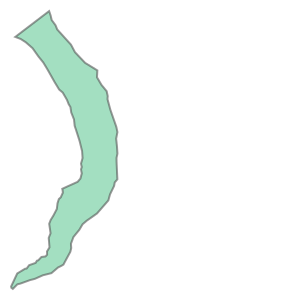

In [18]:
input_polygon